# Load model

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer

import anndata
import scanpy as sc

from scipy.stats import pearsonr, spearmanr

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from adjustText import adjust_text
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
set_seed(123)

In [4]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")

# Filter out unanalyzed clusters
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset_111.obs["leiden_subclusters"]
]
anndataset_111 = anndataset_111[include_cells]

anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter out unanalyzed clusters
include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset_206.obs["leiden_subclusters"]
]
anndataset_206 = anndataset_206[include_cells]

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

anndataset_111.obs["cell_types"] = pd.Categorical([ct.replace('\n', '') for ct in  anndataset_111.obs["cell_types"]])
anndataset_206.obs["cell_types"] = pd.Categorical([ct.replace('\n', '') for ct in  anndataset_206.obs["cell_types"]])

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206],)

[2020-09-08 08:44:54,831] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-08 08:44:54,839] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-08 08:44:54,960] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-08 08:44:55,062] INFO - scvi.dataset.dataset | Downsampled from 15604 to 15604 cells
[2020-09-08 08:44:55,917] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-08 08:44:55,919] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-08 08:44:56,017] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-08 08:44:56,114] INFO - scvi.dataset.dataset | Downsampled from 14870 to 14870 cells
[2020-09-08 08:44:56,366] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-09-08 08:44:56,584] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-08 08:44:56,750] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-

In [5]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    n_batch=dataset.n_batches,
)

In [6]:
model.load_state_dict(torch.load("../spleen_lymph_all/sln_all_intersect.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4119, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [7]:
use_cuda = True
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

In [8]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=25
)

In [9]:
dataset.cell_types

['NKT',
 'CD122+ CD8 T',
 'Transitional B',
 'Mature B',
 'CD4 T',
 'Ifit3-high B',
 'CD8 T',
 'B1 B',
 'Activated CD4 T',
 'MZ B',
 'ICOS-high Tregs',
 'Ifit3-high CD8 T',
 'NK',
 'cDC1s',
 'pDCs',
 'Ly6-high mono',
 'GD T',
 'Tregs',
 'cDC2s',
 'MZ/Marco-high macrophages',
 'Ly6-low mono',
 'Ifit3-high CD4 T',
 'Migratory DCs',
 'Red-pulp macrophages',
 'Erythrocytes',
 'Neutrophils',
 'Plasma B']

# Run one vs all DE

In [10]:
per_cluster_de, cluster_id = full_posterior.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    mode="change",
    delta=0.2
)

per_cluster_de_w_bg, cluster_id_w_bg = full_posterior.one_vs_all_degenes(
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    mode="change",
    sample_bern=False,
    include_bg=True,
    eps=0,
    delta=0.2
)

In [11]:
per_cluster_de[0].columns

Index(['proba_de', 'proba_not_de', 'bayes_factor', 'scale1', 'scale2', 'mean',
       'median', 'std', 'min', 'max', 'confidence_interval_0.5_min',
       'confidence_interval_0.5_max', 'confidence_interval_0.75_min',
       'confidence_interval_0.75_max', 'confidence_interval_0.95_min',
       'confidence_interval_0.95_max', 'confidence_interval_0.99_min',
       'confidence_interval_0.99_max', 'raw_mean1', 'raw_mean2',
       'non_zeros_proportion1', 'non_zeros_proportion2',
       'raw_normalized_mean1', 'raw_normalized_mean2', 'clusters'],
      dtype='object')

In [12]:
full_one_vs_all = pd.concat(per_cluster_de, axis=0)


def filter_de_results(df):
    df = df[
        [
            "proba_de",
            "proba_not_de",
            "bayes_factor",
            "median",
            "mean",
            "scale1",
            "scale2",
            "non_zeros_proportion1",
            "non_zeros_proportion2",
            "raw_mean1",
            "raw_mean2",
            "clusters"
        ]
    ]
    df = df.rename(columns={"bayes_factor": "log_bayes_factor", "median": "LFC_median", "mean": "LFC_mean"})
    return df


full_one_vs_all = filter_de_results(full_one_vs_all)
full_one_vs_all.head()
full_one_vs_all.to_csv("one_vs_all_de_features.csv")

In [13]:
cluster_id

['NKT',
 'CD122+ CD8 T',
 'Transitional B',
 'Mature B',
 'CD4 T',
 'Ifit3-high B',
 'CD8 T',
 'B1 B',
 'Activated CD4 T',
 'MZ B',
 'ICOS-high Tregs',
 'Ifit3-high CD8 T',
 'NK',
 'cDC1s',
 'pDCs',
 'Ly6-high mono',
 'GD T',
 'Tregs',
 'cDC2s',
 'MZ/Marco-high macrophages',
 'Ly6-low mono',
 'Ifit3-high CD4 T',
 'Migratory DCs',
 'Red-pulp macrophages',
 'Erythrocytes',
 'Neutrophils',
 'Plasma B']

In [14]:
ind = np.where(np.array(cluster_id) == "GD T")[0][0]
print(ind)
pro_rows = per_cluster_de[ind].index.str.contains('ADT_')
# per_cluster_de[ind].loc[pro_rows].head(20)
per_cluster_de[ind].sort_values("median", ascending=False).loc["Klrc2"]

16


proba_de                             0.9936
proba_not_de                         0.0064
bayes_factor                        5.04504
scale1                          0.000111667
scale2                           2.1411e-05
mean                                7.32965
median                              7.70153
std                                 4.24186
min                                -11.2442
max                                 20.5591
confidence_interval_0.5_min         5.30266
confidence_interval_0.5_max         10.7301
confidence_interval_0.75_min        3.05716
confidence_interval_0.75_max        12.1808
confidence_interval_0.95_min      -0.560011
confidence_interval_0.95_max        15.6364
confidence_interval_0.99_min       -5.78829
confidence_interval_0.99_max        17.9292
raw_mean1                          0.162264
raw_mean2                         0.0305869
non_zeros_proportion1              0.090566
non_zeros_proportion2               0.01387
raw_normalized_mean1            

## Get markers

In [15]:
# protein markers
groups = {}
num_markers=3
already_selected = set()
for i, cid in enumerate(cluster_id):
    pro_rows = per_cluster_de[i].index.str.contains('ADT_')
    data = per_cluster_de[i].iloc[pro_rows].sort_values("median", ascending=False)
    data = data[data["bayes_factor"] > 0.7]
    groups[cid] = np.array(data.index)[:num_markers]
    groups[cid] = groups[cid][[s not in already_selected for s in groups[cid]]]
    for s in groups[cid]:
        already_selected.add(s)
    groups[cid] = [s.split("_")[1].split("(")[0].split("-Er")[0] for s in groups[cid]]

In [16]:
# RNA markers
gene_groups = {}
num_markers=2
already_selected = set()
for i, cid in enumerate(cluster_id):
    pro_rows = per_cluster_de[i].index.str.contains('ADT_')
    data = per_cluster_de[i].iloc[~pro_rows].sort_values("median", ascending=False)
    data = data[data["bayes_factor"] > 0.7]
    data = data[data["non_zeros_proportion1"] > 0.1]
    gene_groups[cid] = np.array(data.index)[:num_markers]
    gene_groups[cid] = gene_groups[cid][[s not in already_selected for s in gene_groups[cid]]]
    for s in gene_groups[cid]:
        already_selected.add(s)

## Compare with bg to no bg

In [17]:
c=4
pro_rows = per_cluster_de[c].index.str.contains('ADT_')
bg_temp = per_cluster_de[c].iloc[pro_rows]
bg_temp

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_TCRbchain_A0120,0.9810,0.0190,3.944133,60.427364,10.115080,5.091168,6.585472,2.735402,-0.777223,7.867597,...,7.563562,-0.242083,7.744737,60.569027,11.528484,1.000000,0.935284,NaN,NaN,CD4 T
ADT_CD5_A0111,0.9678,0.0322,3.403059,374.367615,79.723511,6.380689,8.829062,4.121657,-2.390231,11.159545,...,10.745611,-1.284205,10.942252,371.111206,79.446411,1.000000,0.995216,NaN,NaN,CD4 T
ADT_CD4_A0001,0.9678,0.0322,3.403059,221.526596,21.375996,7.654834,8.542809,2.756672,-0.834695,9.959564,...,9.708061,-0.407645,9.781043,217.119904,23.019411,1.000000,0.942083,NaN,NaN,CD4 T
ADT_CD54_A0074,0.9426,0.0574,2.798598,1.954021,28.688068,-4.764728,-5.065312,1.999015,-10.531207,6.291542,...,0.225039,-9.725458,0.997005,5.044217,29.295868,0.930295,0.996086,NaN,NaN,CD4 T
ADT_CD357(GITR)_A0193,0.9272,0.0728,2.544453,11.898504,6.939528,2.707241,3.969114,2.321932,-4.661802,7.289957,...,5.532073,-3.343107,5.914377,11.255455,7.763511,0.997297,0.946669,NaN,NaN,CD4 T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADT_CD195(CCR5)_A0376,0.0140,0.9860,-4.254598,0.534596,0.567106,-0.019017,0.000000,0.456836,-5.752496,5.344228,...,0.000000,-3.578260,0.000000,2.783935,2.831073,0.933771,0.929986,NaN,NaN,CD4 T
ADT_TCRr-d_A0121,0.0134,0.9866,-4.299009,0.511506,0.802311,-0.053515,0.000000,0.597228,-7.364916,4.356514,...,0.000000,-4.489549,0.000000,2.962541,3.239731,0.939950,0.941767,NaN,NaN,CD4 T
ADT_FolateReceptorb(FR-b)_A0564,0.0132,0.9868,-4.314250,0.568244,1.073501,-0.053349,0.000000,0.712877,-8.575535,6.693433,...,0.000000,-5.300982,0.000000,3.148291,3.753509,0.940143,0.947183,NaN,NaN,CD4 T
ADT_TER-119-ErythroidCells_A0122,0.0100,0.9900,-4.595119,0.529435,0.579165,-0.016178,0.000000,0.446800,-5.253396,4.850829,...,0.000000,0.000000,3.631666,0.646264,0.728721,0.436571,0.450405,NaN,NaN,CD4 T


0.860886770444687


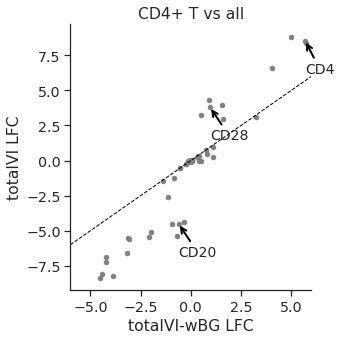

In [18]:
c = 4
pro_rows = per_cluster_de[c].index.str.contains('ADT_')
total_temp = per_cluster_de[c].iloc[pro_rows]


pro_rows = per_cluster_de_w_bg[c].index.str.contains('ADT_')
bg_temp = per_cluster_de_w_bg[c].iloc[pro_rows]

df = pd.DataFrame(index = bg_temp.index)
df["Naive totalVI expected LFC"] = bg_temp["median"].values
total_temp = total_temp.loc[df.index]
df["totalVI expected LFC"] = total_temp["median"]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df.plot.scatter("Naive totalVI expected LFC", "totalVI expected LFC", ax=ax, c="grey")
# ax.set_aspect("equal")
ax.set_xlim(-6, 6)
# ax.set_ylim(-8, 9.5)

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)
pros = ["ADT_CD4_A0001", "ADT_CD28_A0204", "ADT_CD20_A0192"]
for p in pros:
    s = p.split("_")[1]
    ax.annotate(s,
                xy=(df["Naive totalVI expected LFC"][p], df["totalVI expected LFC"][p]), 
                xytext=(df["Naive totalVI expected LFC"][p], df["totalVI expected LFC"][p] - 2.3),
                fontsize=14, 
                arrowprops=dict(arrowstyle='->', color='black', lw=2),
               )
plt.title("CD4+ T vs all")
print(spearmanr(df["Naive totalVI expected LFC"], df["totalVI expected LFC"])[0])

ax.set_ylabel("totalVI LFC")
ax.set_xlabel("totalVI-wBG LFC")

plt.tight_layout()
sns.despine()
fig.savefig("figures/cd4vsall_lfcs.pdf")


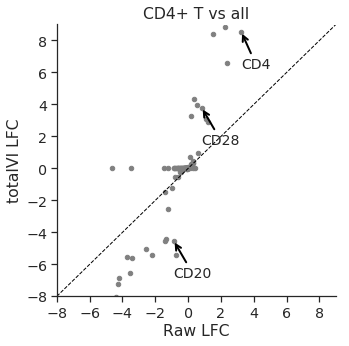

In [19]:
c = 4
pro_rows = per_cluster_de[c].index.str.contains('ADT_')
total_temp = per_cluster_de[c].iloc[pro_rows]


raw_temp = total_temp.copy()
raw_temp["raw_LFC"] = np.log2(raw_temp["raw_mean1"]) - np.log2(raw_temp["raw_mean2"])

df = pd.DataFrame(index = raw_temp.index)
df["Raw LFC"] = raw_temp["raw_LFC"].values
total_temp = total_temp.loc[df.index].copy()
df["totalVI expected LFC"] = total_temp["median"]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df.plot.scatter("Raw LFC", "totalVI expected LFC", ax=ax, c="grey")



pros = ["ADT_CD4_A0001", "ADT_CD28_A0204", "ADT_CD20_A0192"]
for p in pros:
    s = p.split("_")[1]
    ax.annotate(s,
                xy=(df["Raw LFC"][p], df["totalVI expected LFC"][p]), 
                xytext=(df["Raw LFC"][p], df["totalVI expected LFC"][p] - 2.3),
                fontsize=14, 
                arrowprops=dict(arrowstyle='->', color='black', lw=2),
               )
plt.title("CD4+ T vs all")

ax.set_ylabel("totalVI LFC")
ax.set_xlabel("Raw LFC")
# ax.set_aspect("equal")
ax.set_xlim(-8, 9)
ax.set_ylim(-8, 9)
ax.set_xticks(np.arange(-8, 9, 2))

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c="black", linestyle="--", lw=1)

# plt.tight_layout()
sns.despine()
fig.savefig("figures/cd4vsall_lfcs_w_raw.pdf", bbox_inches="tight")


In [20]:
df.loc[(df["totalVI expected LFC"] - df["Raw LFC"]).sort_values(ascending=False).iloc[:25].index].iloc[:10]

,Raw LFC,totalVI expected LFC
ADT_CD90.2_A0075,1.542571,8.378500
ADT_CD5_A0111,2.223797,8.829062
ADT_CD4_A0001,3.237569,8.542809
ADT_CD8b(Ly-3)_A0230,-4.664514,0.000000
ADT_TCRbchain_A0120,2.393377,6.585472
ADT_CD278(ICOS)_A0171,0.376374,4.329347
ADT_CD8a_A0002,-3.507627,0.000000
ADT_CD357(GITR)_A0193,0.535843,3.969114
ADT_CD117(c-Kit)_A0012,0.160543,3.279022
ADT_CD28_A0204,0.826729,3.795942


## Dot plot

In [21]:
dot_adata = anndata.AnnData(np.log1p(dataset.protein_expression))
dot_adata.var.index = dataset.protein_names
dot_adata.raw = dot_adata
dot_adata.X = denoised_proteins
dot_adata.obs["cell_types"] = pd.Categorical([dataset.cell_types[l] for l in dataset.labels.ravel()])
dot_adata.var["protein_names"] = [s.split("_")[1].split("(")[0].split("-Er")[0] for s in dataset.protein_names]

In [22]:
categories = list(dot_adata.obs["cell_types"].cat.categories)
groups_new = {}
marker_pros = set()
for c in categories:
    groups_new[c] = groups[c]
for c in groups_new:
    for p in groups_new[c]:
        marker_pros.add(p)
marker_pros = list(marker_pros)

In [23]:
groups_new

{'Activated CD4 T': [],
 'B1 B': ['CD172a', 'Ly-6A-E', 'CD29'],
 'CD122+ CD8 T': ['CD8b', 'CD5'],
 'CD4 T': ['CD4'],
 'CD8 T': ['CD8a'],
 'Erythrocytes': ['CD71', 'TER-119', 'CD24'],
 'GD T': [],
 'ICOS-high Tregs': [],
 'Ifit3-high B': ['CD23', 'CD21-CD35'],
 'Ifit3-high CD4 T': [],
 'Ifit3-high CD8 T': [],
 'Ly6-high mono': ['CD115'],
 'Ly6-low mono': ['F4-80'],
 'MZ B': [],
 'MZ/Marco-high macrophages': ['Tim-4', 'CD106'],
 'Mature B': ['IgD', 'I-A-I-E', 'CD38'],
 'Migratory DCs': ['CD62P'],
 'NK': ['NK-1.1', 'CD335', 'CD357'],
 'NKT': ['CD73', 'CD90.2', 'CD28'],
 'Neutrophils': ['CD43'],
 'Plasma B': ['CD36'],
 'Red-pulp macrophages': [],
 'Transitional B': ['CD19', 'CD45R-B220', 'CD79b'],
 'Tregs': [],
 'cDC1s': ['CD11c', 'XCR1'],
 'cDC2s': [],
 'pDCs': ['Ly-6C']}

         Falling back to preprocessing with `sc.pp.pca` and default params.


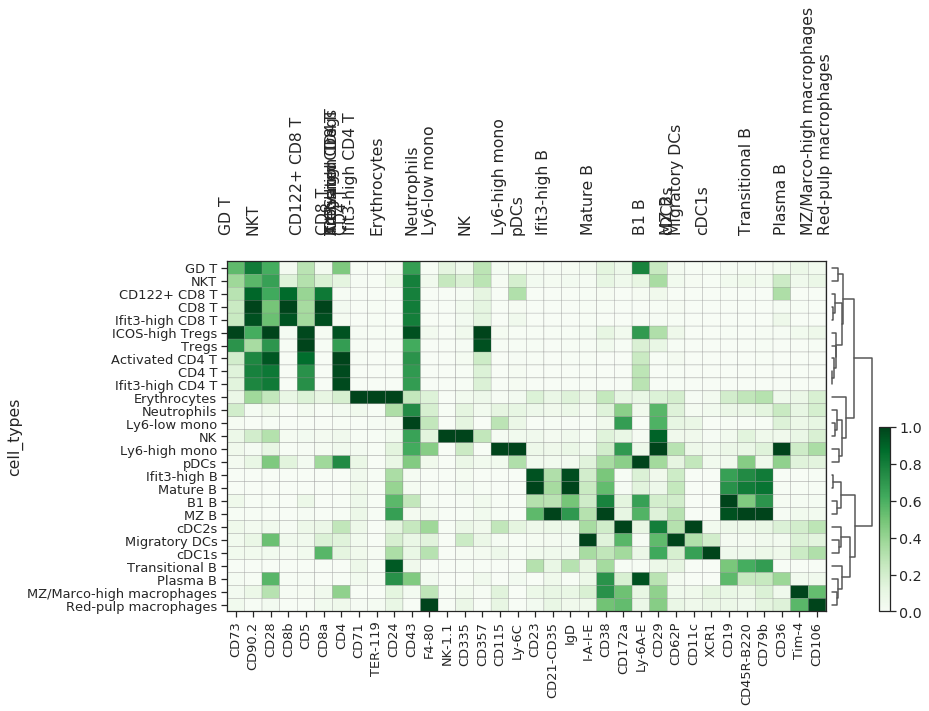

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[10.88, 0.8, 0.2])

In [24]:
sc.pl.matrixplot(
    dot_adata,
    groups_new,
    groupby="cell_types",
    gene_symbols="protein_names",
    dendrogram=True,
    use_raw=False,
    swap_axes=False,
    save="pro_swap.pdf",
    cmap="Greens",
    standard_scale="var"
)

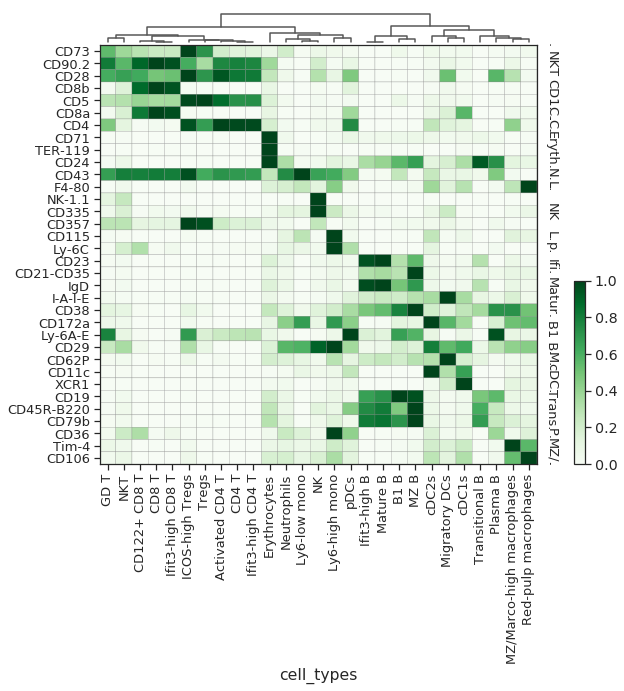

GridSpec(2, 3, height_ratios=[0.5, 6.800000000000001], width_ratios=[8.1, 0.4, 0.2])

In [25]:
sc.pl.matrixplot(
    dot_adata,
    groups_new,
    groupby="cell_types",
    gene_symbols="protein_names",
    dendrogram=True,
    use_raw=False,
    swap_axes=True,
    save="pro.pdf",
    cmap="Greens",
    standard_scale="var"
)

### Dot plot RNA

In [26]:
dot_adata_rna = anndata.AnnData(dataset.X)
dot_adata_rna.var.index = dataset.gene_names
dot_adata_rna.raw = dot_adata
dot_adata_rna.X = denoised_genes
dot_adata_rna.obs["cell_types"] = pd.Categorical([dataset.cell_types[l] for l in dataset.labels.ravel()])
dot_adata_rna.uns["dendrogram_cell_types"] = dot_adata.uns["dendrogram_cell_types"]

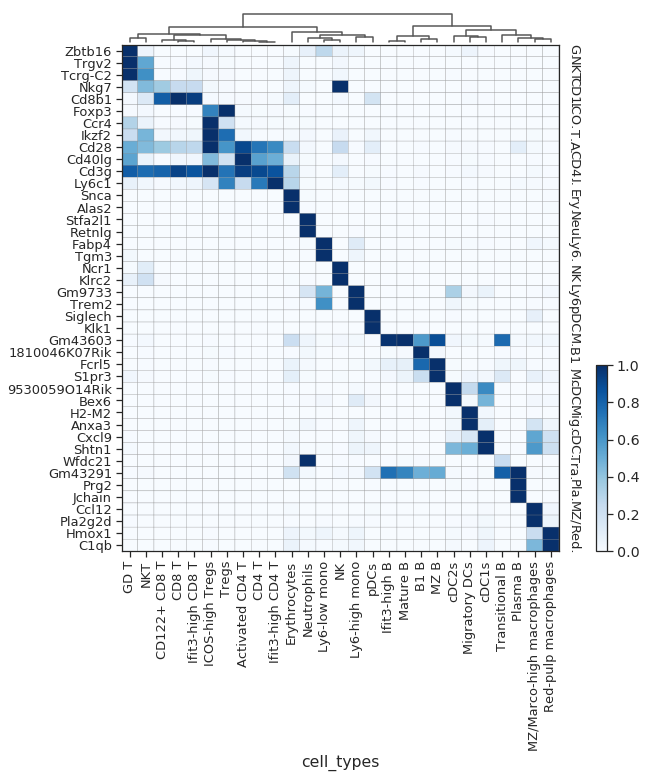

GridSpec(2, 3, height_ratios=[0.5, 8.4], width_ratios=[8.1, 0.4, 0.2])

In [27]:
categories = list(dot_adata_rna.obs["cell_types"].cat.categories)
groups_new_genes = {}
marker_genes = set()
for c in categories:
    groups_new_genes[c] = gene_groups[c]
for c in groups_new_genes:
    for p in groups_new_genes[c]:
        marker_genes.add(p)
marker_genes = list(marker_genes)

sc.pl.matrixplot(
    dot_adata_rna,
    groups_new_genes,
    groupby="cell_types",
#     gene_symbols="protein_names",
    dendrogram=True,
    use_raw=False,
    standard_scale="var",
    cmap="Blues",
    swap_axes=True,
    save=".pdf",
)

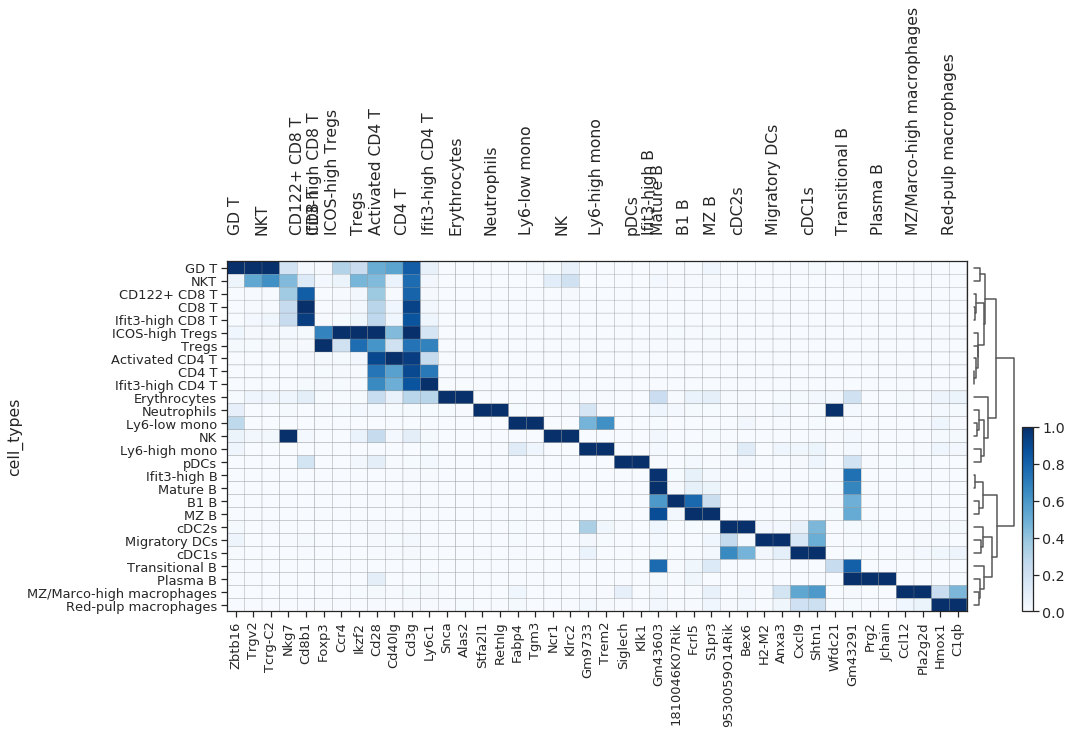

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[13.44, 0.8, 0.2])

In [28]:
sc.pl.matrixplot(
    dot_adata_rna,
    groups_new_genes,
    groupby="cell_types",
#     gene_symbols="protein_names",
    dendrogram=True,
    use_raw=False,
    standard_scale="var",
    cmap="Blues",
    swap_axes=False,
    save="swap.pdf",
)

# One vs one

In [29]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 30474 x 4005
    dataset_versions: 'norm_X'
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'protein_expression', 'batch_indices', 'labels', 'local_means', 'local_vars'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

In [30]:
dataset.cell_types

['NKT',
 'CD122+ CD8 T',
 'Transitional B',
 'Mature B',
 'CD4 T',
 'Ifit3-high B',
 'CD8 T',
 'B1 B',
 'Activated CD4 T',
 'MZ B',
 'ICOS-high Tregs',
 'Ifit3-high CD8 T',
 'NK',
 'cDC1s',
 'pDCs',
 'Ly6-high mono',
 'GD T',
 'Tregs',
 'cDC2s',
 'MZ/Marco-high macrophages',
 'Ly6-low mono',
 'Ifit3-high CD4 T',
 'Migratory DCs',
 'Red-pulp macrophages',
 'Erythrocytes',
 'Neutrophils',
 'Plasma B']

In [31]:
ct = "ICOS-high Tregs"

## Scanpy 1v1

In [32]:
sc.tl.rank_genes_groups(
    dot_adata,
    "cell_types",
    use_raw=True,
    groups=[ct],
    reference="CD4 T",
    method="t-test",
    n_genes=dot_adata.X.shape[1],
    key_added="rank_genes_groups_ttest_tregs",
    rankby_abs=True
)

sc.tl.rank_genes_groups(
    dot_adata,
    "cell_types",
    use_raw=True,
    groups=[ct],
    reference="CD4 T",
    method="wilcoxon",
    n_genes=dot_adata.X.shape[1],
    key_added="rank_genes_groups_wilcox_tregs",
    rankby_abs=True
)

In [33]:
sc.get.rank_genes_groups_df(dot_adata, ct, key="rank_genes_groups_ttest_tregs").iloc[:50]

,scores,names,logfoldchanges,pvals,pvals_adj
0,43.826233,ADT_CD73_A0077,2.944863,4.806104e-174,5.286714e-172
1,38.316616,ADT_CD29_A0570,2.333014,3.056478e-145,1.681063e-143
2,30.934586,ADT_CD38_A0557,2.336754,1.444456e-114,5.296339e-113
3,29.532900,ADT_CD304(Neuropilin-1)_A0552,2.795640,2.912285e-107,6.407026e-106
4,29.379198,ADT_CD54_A0074,2.468364,2.845656e-108,7.825555e-107
5,27.398449,ADT_CD278(ICOS)_A0171,1.841337,4.673336e-98,8.567782e-97
6,-25.694302,ADT_CD62L_A0112,-2.457350,4.146250e-90,5.701093e-89
7,25.574642,ADT_CD150(SLAM)_A0203,1.496129,1.697922e-90,2.668164e-89
8,25.296112,ADT_CD357(GITR)_A0193,2.040121,1.713171e-88,2.093876e-87
9,24.615236,ADT_CD11a_A0595,1.081977,9.955626e-87,1.095119e-85


In [34]:
labels = dataset.labels.ravel()

group1 = np.where(np.array(dataset.cell_types) == ct)[0]

# foreground with zero background
de = full_posterior.differential_expression_score(
    idx1=labels==group1,
    idx2=labels==4,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
)


# background and foreground
de_w_bg = full_posterior.differential_expression_score(
    idx1=labels==group1,
    idx2=labels==4,
    n_samples=5000,
    use_permutation=False,
    delta=0.2,
    mode="change",
    sample_bern=False,
    include_bg=True,
    eps=0,
)

## totalVI result table

In [35]:
de["clusters"] = ["ICOS-high Tregs"] * len(de)
de_for_csv = filter_de_results(de.copy())
de_for_csv.to_csv("icos_high_treg_vs_cd4.csv")
pro_rows = de.index.str.contains('ADT_')
de = de.iloc[pro_rows]
de[de["bayes_factor"] > 0.7]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
ADT_CD150(SLAM)_A0203,0.9846,0.0154,4.157867,44.920277,14.064299,1.528436,1.648061,1.029774,-6.588800,7.642914,...,2.925583,-4.524505,3.172918,43.273148,13.334620,1.000000,1.000000,NaN,NaN,ICOS-high Tregs
ADT_CD278(ICOS)_A0171,0.9820,0.0180,3.999219,65.262817,13.228371,1.771044,1.947635,1.676214,-6.184385,5.141615,...,4.763400,-5.208790,4.497860,68.444443,12.933385,1.000000,0.999614,NaN,NaN,ICOS-high Tregs
ADT_CD357(GITR)_A0193,0.9804,0.0196,3.912431,70.773384,11.929384,2.197653,2.388749,1.299679,-5.860282,8.042962,...,4.186404,-0.799720,4.635489,69.041664,11.255455,1.000000,0.997297,NaN,NaN,ICOS-high Tregs
ADT_CD73_A0077,0.9792,0.0208,3.851782,67.103409,10.326983,3.403040,2.644103,2.758542,-6.320880,8.847803,...,8.129423,-5.281602,8.658263,75.951385,10.517088,1.000000,0.975478,NaN,NaN,ICOS-high Tregs
ADT_CD49d_A0078,0.9706,0.0294,3.496919,11.751268,8.338111,-1.238794,0.000000,2.920637,-5.950846,6.893083,...,2.231426,-4.917916,6.177074,15.557870,7.958100,0.960648,0.997104,NaN,NaN,ICOS-high Tregs
ADT_CD11a_A0595,0.9546,0.0454,3.045780,243.351105,100.819565,1.212366,1.252247,0.653666,-6.792628,2.914992,...,2.397871,-0.597938,2.623666,224.106476,98.351227,1.000000,1.000000,NaN,NaN,ICOS-high Tregs
ADT_CD274(B7-H1_PD-L1)_A0190,0.9388,0.0612,2.730455,20.015888,11.122005,0.786163,0.777712,1.111984,-6.842104,6.332097,...,2.387878,-4.692329,5.571323,19.261574,10.679089,1.000000,1.000000,NaN,NaN,ICOS-high Tregs
ADT_Ly-6A-E(Sca-1)_A0130,0.9184,0.0816,2.420804,158.024261,68.581871,-0.089897,1.213798,5.139546,-9.185229,10.121099,...,9.198392,-8.505203,9.760573,179.004623,70.198105,1.000000,1.000000,NaN,NaN,ICOS-high Tregs
ADT_CD86_A0200,0.9034,0.0966,2.235587,27.071238,12.676332,0.875061,1.014091,3.428508,-7.063302,7.721240,...,6.839957,-5.990492,7.339275,27.520834,13.512068,0.990741,0.993435,NaN,NaN,ICOS-high Tregs
ADT_CD48_A0429,0.9016,0.0984,2.215130,67.645760,38.281395,0.758436,0.772818,0.674761,-7.236321,7.729463,...,1.799772,-0.584359,2.157829,67.039352,37.586407,1.000000,1.000000,NaN,NaN,ICOS-high Tregs


In [36]:
pro_rows = de_w_bg.index.str.contains('ADT_')
de_w_bg = de_w_bg.iloc[pro_rows]
de_w_bg[de_w_bg["bayes_factor"] > 0.7].iloc[:50]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,mean,median,std,min,max,...,confidence_interval_0.95_min,confidence_interval_0.95_max,confidence_interval_0.99_min,confidence_interval_0.99_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
ADT_CD73_A0077,0.9934,0.0066,5.014062,65.788589,10.761932,2.643554,2.640227,1.140843,-2.228567,6.012769,...,0.546199,4.923275,-0.026749,5.480020,75.951385,10.517088,1.000000,0.975478,NaN,NaN
ADT_CD304(Neuropilin-1)_A0552,0.9872,0.0128,4.345427,18.620842,2.141538,2.838275,3.025433,1.015899,-1.448889,4.738125,...,0.784272,4.494568,0.097336,4.553569,20.560184,2.122031,0.983796,0.865032,NaN,NaN
ADT_CD54_A0074,0.9864,0.0136,4.283991,29.233519,4.919107,2.362959,2.431094,0.985515,-3.210700,5.910127,...,0.081334,4.066208,-0.192611,5.474850,32.472221,5.044217,0.993056,0.930295,NaN,NaN
ADT_CD29_A0570,0.9858,0.0142,4.240211,50.639618,9.662461,2.266863,2.366807,0.718493,-1.034000,4.521941,...,0.589483,3.548178,-0.050378,3.768197,56.599537,9.452983,1.000000,0.998455,NaN,NaN
ADT_CD150(SLAM)_A0203,0.9850,0.0150,4.184591,44.108570,13.605902,1.620002,1.665632,0.681050,-1.368214,3.401625,...,0.328234,2.874402,-0.118920,3.205535,43.273148,13.334620,1.000000,1.000000,NaN,NaN
ADT_CD38_A0557,0.9814,0.0186,3.965818,49.131588,8.429662,2.259035,2.311042,1.065543,-2.633358,5.928101,...,0.002028,4.106468,-0.241566,5.517181,47.569443,7.603785,1.000000,0.989573,NaN,NaN
ADT_CD357(GITR)_A0193,0.9782,0.0218,3.803804,69.393555,11.459112,2.274986,2.407979,1.136408,-1.870128,4.850485,...,0.239681,4.148371,-0.176332,4.502617,69.041664,11.255455,1.000000,0.997297,NaN,NaN
ADT_CD278(ICOS)_A0171,0.9746,0.0254,3.647278,63.541824,12.798028,1.987033,1.935463,1.056998,-1.501545,5.299236,...,-0.057545,4.085410,-0.598239,4.690907,68.444443,12.933385,1.000000,0.999614,NaN,NaN
ADT_CD184(CXCR4)_A0444,0.9636,0.0364,3.276107,10.242922,4.232039,1.151172,1.106369,0.599610,-0.546268,2.737484,...,0.061653,2.277623,-0.098130,2.568528,10.511574,4.119521,0.993056,0.979533,NaN,NaN
ADT_CD200(OX2)_A0079,0.9530,0.0470,3.009467,19.558348,7.332527,1.276423,1.273675,0.798504,-2.455763,4.195474,...,-0.125334,2.915447,-0.906554,3.547246,20.120371,7.478278,1.000000,0.997104,NaN,NaN


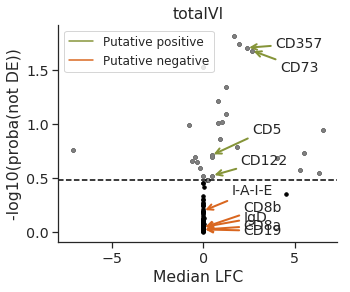

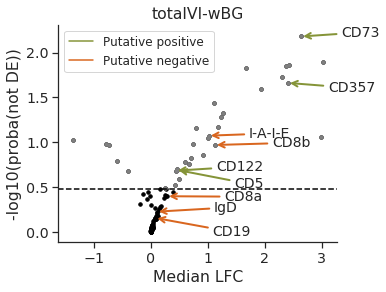

In [37]:
plot_value = "median"
BF_CUT = 0.7

data1 = de
data1["LFC_ct_means"] = np.log2(data1["scale1"]) - np.log2(data1["scale2"])

s = 12
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4))
fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
ax = [ax1, ax2]

ax[0].scatter(data1[plot_value], -np.log10(data1["proba_not_de"]), s=s, c="black", label=None)
subset1 = data1["bayes_factor"] > BF_CUT
ax[0].scatter(
    data1[plot_value][subset1],
    -np.log10(data1["proba_not_de"][subset1]),
    s=s,
    c="grey",
#     label="{} DE proteins".format(sum(subset1)),
    label=None
)

data2 = de_w_bg
data2["LFC_ct_means"] = np.log2(data2["raw_mean1"]) - np.log2(data2["raw_mean2"])

subset2 = data2["bayes_factor"] > BF_CUT

ax[1].scatter(data2[plot_value], -np.log10(data2["proba_not_de"]), s=s, c="black", label=None)
ax[1].scatter(
    data2[plot_value][subset2],
    -np.log10(data2["proba_not_de"][subset2]),
    s=s,
    c="grey",
#     label="{} DE proteins".format(sum(subset2)),
    label=None
)

data = [data1, data2]
pros = [
        "ADT_CD73_A0077",
        "ADT_CD357(GITR)_A0193",
        "ADT_CD122(IL-2Rb)_A0227",
        "ADT_I-A-I-E_A0117",
        "ADT_CD8b(Ly-3)_A0230",
        "ADT_CD19_A0093",
        "ADT_IgD_A0571",
        "ADT_CD5_A0111",
        "ADT_CD8a_A0002",
    ]
offset_x = [0.7, 0.7, 0.7, 0.7, 1, 1, 1, 1, 1]
offset_y = [0, -0.1, 0.0, -0.02, -0.02, -0.2, 0, -0.2, -0.05]
offset_y_big = [-0.2, 0, 0.1, 0.15, 0.15, -0.05, 0.05, 0.2, 0]
a_color = ["#859438", "#859438", "#859438", "#D9661F", "#D9661F", "#D9661F", "#D9661F", "#859438", "#D9661F"]
num = [2.2, 1]
for d, a, n in zip(data, ax, num):
    a.axhline(-np.log10(1 - np.exp(BF_CUT)/(1+np.exp(BF_CUT))), linestyle="--", c="black", lw=1.5)
    a.set_ylabel("-log10(proba(not DE))")
    ts = []
    for p, ox, oy, oyb, ac in zip(pros, offset_x, offset_y, offset_y_big, a_color):
        if n == num[0]:
            oy = oyb
        s = p.split("_")[1]
        s = s.split("(")[0]
        a.annotate(
            s,
            xy=(d[plot_value][p], -np.log10(d["proba_not_de"][p])),
            xytext=(d[plot_value][p] + ox*n, -np.log10(d["proba_not_de"][p]) + oy),
            fontsize=14,
            arrowprops=dict(arrowstyle="->", color=ac, lw=2),
        )
        
if plot_value == "mean":
    ax[0].set_xlabel("Mean LFC")
    ax[1].set_xlabel("Mean LFC")
elif plot_value == "median":
    ax[0].set_xlabel("Median LFC")
    ax[1].set_xlabel("Median LFC")
else:
    ax[0].set_xlabel("LFC of cell type means")
    ax[1].set_xlabel("LFC of cell type means")

ax[0].set_title("totalVI")
ax[1].set_title("totalVI-wBG")
# ax[0].legend(loc="lower right")
# ax[1].legend(loc="lower right")
# ax[0].set_xlim(-1.5, 6)
# ax[1].set_xlim(-10, 6)

# plt.tight_layout()

for a in ax:
    a.plot([], [], label='Putative positive', color="#859438")
    a.plot([], [], label='Putative negative', color="#D9661F")

    a.legend(prop={'size': 12})


sns.despine(fig1)
sns.despine(fig2)
fig1.savefig("figures/tregs_totalVI.pdf", bbox_inches="tight")
fig2.savefig("figures/tregs_totalVI_no_bg.pdf", bbox_inches="tight")

In [38]:
import matplotlib.lines as mlines
def volcano_plot(adata, key, title, legend=True, data=None, ox=None, oy=None):
    test_name = key.split("_")[-2]
    s = 12
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    if data is None:
        data = sc.get.rank_genes_groups_df(adata, ct, key=key)
    data = data.set_index("names")
    ax.scatter(data["logfoldchanges"], -np.log10(data["pvals_adj"]), s=s, c="black", label=None)
    lfc_cut = 0
    subset3 = np.logical_and(data["pvals_adj"] < 0.05, np.abs(data["logfoldchanges"]) >= lfc_cut)
    print(sum(subset3))
    ax.scatter(
        data["logfoldchanges"][subset3],
        -np.log10(data["pvals_adj"][subset3]),
        s=s,
        c="grey",
        label="{} DE proteins".format(sum(subset3)),
    )

    offset_x = [1.2, 1.0, -2.5, -2.5, -2.5]
    offset_y = [-0.2, 0, 0.1, -0.01, -0.1]
    ax.axhline(-np.log10(0.05), linestyle="--", c="black", lw=1)
    if lfc_cut > 0:
        ax.axvline(lfc_cut, linestyle="--", c="black", lw=1.5)
        ax.axvline(-lfc_cut, linestyle="--", c="black", lw=1.5)


    pros = [
        "ADT_CD73_A0077",
        "ADT_CD357(GITR)_A0193",
        "ADT_CD122(IL-2Rb)_A0227",
        "ADT_I-A-I-E_A0117",
        "ADT_CD8b(Ly-3)_A0230",
        "ADT_CD19_A0093",
        "ADT_IgD_A0571",
        "ADT_CD5_A0111",
        "ADT_CD8a_A0002"
    ]
    if ox is None:
        offset_x = [-1.3, -1.7, 1, 1, 1.5, -1.5, -1.5, -0.5, -2]
    else:
        offset_x = ox
    if oy is None:
        offset_y = [-14, 0, -5, 20, 2.5, 20, 20, 40, 5]
    else:
        offset_y = oy
    a_color = ["#859438", "#859438", "#859438", "#D9661F", "#D9661F", "#D9661F", "#D9661F", "#859438", "#D9661F"]
    for p, ox, oy, ac in zip(pros, offset_x, offset_y, a_color):
        s = p.split("_")[1]
        s = s.split("(")[0]
        ax.annotate(
            s,
            xy=(data["logfoldchanges"][p], -np.log10(data["pvals_adj"])[p]),
            xytext=(data["logfoldchanges"][p] + ox, -np.log10(data["pvals_adj"])[p] + oy),
            fontsize=14,
            arrowprops=dict(arrowstyle="->", color=ac, lw=2),
        )

    ax.set_ylabel(r"$-\log_{10}$(adj $p$-value)")
    if test_name != "Poisson":
        ax.set_xlabel("LFC of cell type mean")
    else:
        ax.set_xlabel("LFC")
    plt.title(title)


    if legend is True:
        green_line = mlines.Line2D([], [], color="#859438", linestyle='-',
                                  markersize=10, label='Putative positive')
        orange_line = mlines.Line2D([], [], color="#D9661F", linestyle='-',
                                  markersize=10, label='Putative negative')

        plt.legend(handles=[green_line, orange_line], prop={'size': 14})


    sns.despine()
    fig.savefig("figures/tregs_{}.pdf".format(test_name), bbox_inches="tight")

78


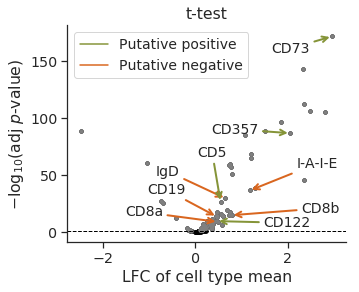

In [39]:
volcano_plot(dot_adata, "rank_genes_groups_ttest_tregs", "t-test", legend=True)

78


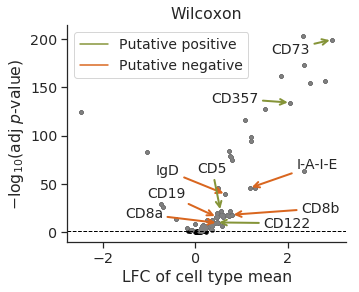

In [40]:
volcano_plot(dot_adata, "rank_genes_groups_wilcox_tregs", "Wilcoxon", legend=True)

In [41]:
zeileis_28 = [
    "#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#4a6fe3",
    "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a", "#11c638", "#8dd593",
    "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7",
    "#f3e1eb", "#f6c4e1", "#f79cd4",
    '#7f7f7f', "#c7c7c7", "#1CE6FF", "#336600",  # these last ones were added,
]
from scanpy.plotting._tools.scatterplots import _get_color_values
color_values = _get_color_values(dot_adata, "cell_types")[0]

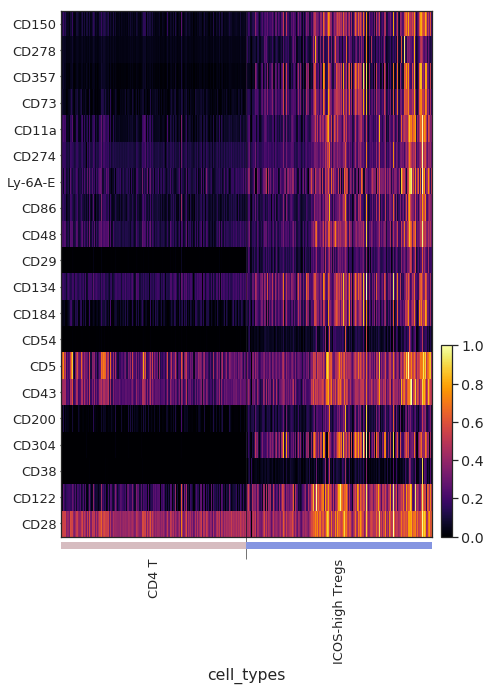

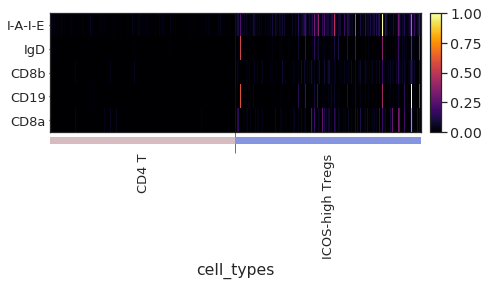

GridSpec(3, 3, height_ratios=[0, 2.37, 0.13], width_ratios=[7, 0, 0.2])

In [42]:
data = de[de["bayes_factor"] >= 0.7]
data = data[data["median"] > 0]

# var_names = list(data.index) + list(data_2_v_1.index)
var_names_whole = list(data.index) + [
    "ADT_I-A-I-E_A0117",
    "ADT_IgD_A0571",
    "ADT_CD8b(Ly-3)_A0230",
    "ADT_CD19_A0093",
    "ADT_CD8a_A0002",
]
var_names = [vn.split("_")[1].split("(")[0].split("-Er")[0] for vn in var_names_whole]

cd4_inds = np.random.permutation(
    np.where(dot_adata.obs["cell_types"].values == "CD4 T")[0]
)
# subset to number of tregs
cd4_inds = cd4_inds[: sum(dot_adata.obs["cell_types"] == ct)]
cd4_mask = np.zeros((len(dot_adata.obs["cell_types"]))).astype(np.bool)
cd4_mask[cd4_inds] = True

subset = np.logical_or(cd4_mask, dot_adata.obs["cell_types"] == ct)

subset_adata = dot_adata[subset].copy()
# subset_adata.X = np.log1p(subset_adata.X)
# min_x = np.min(subset_adata.X, axis=0)
# max_x = np.max(subset_adata.X, axis=0)
# subset_adata.X = (subset_adata.X - min_x) / (max_x - min_x)
# subset_adata.X = subset_adata.X / np.max(subset_adata.X, axis=0)

subset_adata.uns["cell_types_colors"] = [
    color_values[np.where(dot_adata.obs["cell_types"].values == "CD4 T")[0]][0],
    color_values[np.where(dot_adata.obs["cell_types"].values == ct)[0]][0],
]


sc.pl.heatmap(
    subset_adata,
    var_names[:-5],
    groupby="cell_types",
    gene_symbols="protein_names",
    use_raw=False,
    swap_axes=True,
    save="tregs_de.pdf",
    cmap="inferno",
    standard_scale="var",
    figsize=(7, 10),
    show_gene_labels=True,
)

sc.pl.heatmap(
    subset_adata,
    var_names[-5:],
    groupby="cell_types",
    gene_symbols="protein_names",
    use_raw=False,
    swap_axes=True,
    save="tregs_fp.pdf",
    cmap="inferno",
    standard_scale="var",
    figsize=(7, 2.5),
    show_gene_labels=True,
)

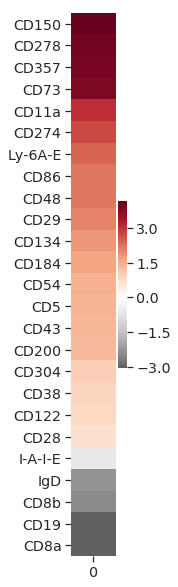

In [43]:
proba_de_df = pd.DataFrame(index=var_names, data=de.loc[var_names_whole]["bayes_factor"].values)
fig, ax = plt.subplots(figsize=(1, 10))
sns.heatmap(proba_de_df, cmap="RdGy_r", ax=ax, center=0)#, vmin=0, vmax=1)
fig.savefig("figures/treg_example_proba_de.pdf", bbox_inches="tight")

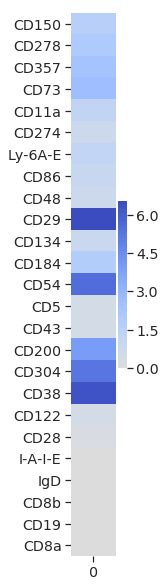

In [44]:
proba_de_df = pd.DataFrame(index=var_names, data=de.loc[var_names_whole]["median"].values)
fig, ax = plt.subplots(figsize=(1, 10))
sns.heatmap(proba_de_df, cmap="coolwarm_r", ax=ax, center=0.001)#, vmin=0, vmax=1)
fig.savefig("figures/treg_example_lfc.pdf", bbox_inches="tight")

## GLM

In [45]:
import sys
sys.path.append("../utils/")
from utils import glm_de
dot_adata.obs["batch"] = dataset.batch_indices.ravel()

In [46]:
df = glm_de(dot_adata, "ICOS-high Tregs", "CD4 T", use_raw=True, family="Poisson")

In [47]:
df["logfoldchanges"] = df["coeff"]
df["pvals_adj"] = df["pvals_adj"] + 1e-95
df["names"] = df.index
df

,pvals,pvals_adj,coeff,logfoldchanges,names
ADT_CD304(Neuropilin-1)_A0552,0.000000e+00,1.000000e-95,2.270675,2.270675,ADT_CD304(Neuropilin-1)_A0552
ADT_CD25_A0097,0.000000e+00,1.000000e-95,2.230925,2.230925,ADT_CD25_A0097
ADT_CD73_A0077,0.000000e+00,1.000000e-95,1.975224,1.975224,ADT_CD73_A0077
ADT_CD54_A0074,0.000000e+00,1.000000e-95,1.859457,1.859457,ADT_CD54_A0074
ADT_CD38_A0557,0.000000e+00,1.000000e-95,1.831156,1.831156,ADT_CD38_A0557
...,...,...,...,...,...
ADT_CD90.2_A0075,0.000000e+00,1.000000e-95,-0.207526,-0.207526,ADT_CD90.2_A0075
ADT_CD127(IL-7Ra)_A0198,4.509851e-53,1.102408e-52,-0.456521,-0.456521,ADT_CD127(IL-7Ra)_A0198
ADT_CD55(DAF)_A0558,0.000000e+00,1.000000e-95,-0.530553,-0.530553,ADT_CD55(DAF)_A0558
ADT_TCRbchain_A0120,0.000000e+00,1.000000e-95,-0.597418,-0.597418,ADT_TCRbchain_A0120


92


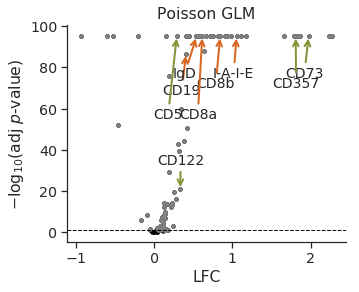

In [48]:
volcano_plot(
    dot_adata,
    "rank_genes_groups_Poisson_tregs",
    "Poisson GLM",
    legend=False,
    data=df,
    ox=[-0.3] * 9,
    oy= [-20, -25, 12, -20, -25, -20, -20, -40, -40],
)